In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

In [33]:
from google.colab import files

# Upload file(s)
uploaded = files.upload()

# If you uploaded a single file, you can access it like this:
for filename in uploaded.keys():
    print(f"User uploaded file: {filename}")


Saving Crop_production.csv to Crop_production (1).csv
User uploaded file: Crop_production (1).csv


In [35]:
df=pd.read_csv('Crop_production.csv')
df

,Unnamed: 0,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
0,0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,7300.0,9400.0,1.287671
1,1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,3300.0,1000.0,0.303030
2,2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,10100.0,10200.0,1.009901
3,3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,2800.0,4900.0,1.750000
4,4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,1300.0,500.0,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99844,99844,west bengal,rabi,wheat,60,30,30,6.70,152.54,22.280000,2013.0,5152.0,2.559364
99845,99845,west bengal,summer,maize,80,40,20,5.68,182.50,29.200000,258.0,391.0,1.515504
99846,99846,west bengal,summer,rice,80,40,40,5.64,182.50,29.200000,105.0,281.0,2.676190
99847,99847,west bengal,rabi,rice,80,40,40,5.42,152.54,22.280000,152676.0,261435.0,1.712352


In [5]:
df.corr(numeric_only=True)['Production_in_tons']


,Production_in_tons
Unnamed: 0,-0.021017
N,0.101564
P,-0.020831
K,-0.019742
pH,0.097403
rainfall,-0.096897
temperature,-0.033570
Area_in_hectares,0.737676
Production_in_tons,1.000000
Yield_ton_per_hec,0.043175


In [6]:
X=df.drop(['Unnamed: 0','Production_in_tons'],axis=1)
Y=df['Production_in_tons']
X.head()

,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Yield_ton_per_hec
0,andhra pradesh,kharif,cotton,120.0,40.0,20.0,5.46,654.34,29.266667,7300.0,1.287671
1,andhra pradesh,kharif,horsegram,20.0,60.0,20.0,6.18,654.34,29.266667,3300.0,0.303030
2,andhra pradesh,kharif,jowar,80.0,40.0,40.0,5.42,654.34,29.266667,10100.0,1.009901
3,andhra pradesh,kharif,maize,80.0,40.0,20.0,5.62,654.34,29.266667,2800.0,1.750000
4,andhra pradesh,kharif,moong,20.0,40.0,20.0,5.68,654.34,29.266667,1300.0,0.384615


In [7]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_col=X.select_dtypes(include=['number']).columns.tolist()

In [8]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [9]:
preprocessor=ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(sparse_output=False,drop='first'),categorical_cols),
        ('num',StandardScaler(),numerical_col)
    ]
)

In [10]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)


In [11]:
import numpy as np

print(np.isnan(X_train).sum())
print(np.isnan(Y_train).sum())


8
1


In [12]:
# Replace NaN with column mean (or median)
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [13]:
# Remove rows with NaN in target
mask = ~np.isnan(Y_train)
X_train = X_train[mask]
Y_train = Y_train[mask]


In [14]:
mask = ~np.isnan(Y_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

In [15]:
# 2. Scale targets (StandardScaler expects 2D input, so reshape first)
y_scaler = StandardScaler()

Y_train = y_scaler.fit_transform(Y_train.to_numpy().reshape(-1, 1)).ravel()
Y_test  = y_scaler.transform(Y_test.to_numpy().reshape(-1, 1)).ravel()

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

In [17]:
# For hyper parameter tunning
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [18]:
import keras_tuner as kt

In [19]:
# Now Lets start make model

def build_model(hp):
  model=Sequential()
  counter=0

  for i in range (hp.Int('num_layers',2,10)):
    if counter==0:
      #Input layer
      model.add(
          Dense(
              units=hp.Int('units'+str(i),min_value=8,max_value=232,step=10),
              activation=hp.Choice('activation'+str(i), values=['relu','tanh','selu']),
              input_dim=X_train.shape[1]
          )
      )
      model.add(Dropout(hp.Choice('dropout',values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])))
    else:
      model.add(
          Dense(
              units=hp.Int('units'+str(i),min_value=8,max_value=232,steps=10),
              activation=hp.Choice('activation'+str(i), values=['relu','tanh','selu'])
          )
      )
      model.add(Dropout(hp.Choice('dropout',values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])))

  counter+=1
  model.add(Dense(1,activation='linear'))
  model.compile(
      optimizer=hp.Choice('optimizer',values=['adam','sgd','rmsprop']),
      loss='mse',
      metrics=['mse']
  )
  return model



In [20]:
tuner=kt.RandomSearch(build_model,objective='val_loss',max_trials=3,directory='my_dir')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
tuner.search(X_train,Y_train,epochs=5,validation_data=(X_test,Y_test))

Trial 3 Complete [00h 00m 14s]
val_loss: 0.3815164864063263

Best val_loss So Far: 0.09434854984283447
Total elapsed time: 00h 00m 48s


In [22]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 4,
 'units0': 178,
 'activation0': 'selu',
 'dropout': 0.1,
 'units1': 198,
 'activation1': 'relu',
 'optimizer': 'rmsprop',
 'units2': 88,
 'activation2': 'tanh',
 'units3': 18,
 'activation3': 'relu',
 'units4': 198,
 'activation4': 'relu'}

In [23]:
model=tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',min_delta=0.001,patience=5,verbose=0,mode='auto')

In [25]:
history=model.fit(X_train,Y_train,epochs=100,initial_epoch=5,validation_data=(X_test,Y_test),callbacks=callback)

Epoch 6/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 7/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1270 - mse: 0.1270 - val_loss: 0.0902 - val_mse: 0.0902
Epoch 8/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0929 - val_mse: 0.0929
Epoch 9/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1297 - mse: 0.1297 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 10/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 11/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 12/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1147 - mse: 0.1147 - val_loss: 0.0679 - val_mse: 0.0679
Epoch 13/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1075 - mse: 0.1075 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 14/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 178)            │        12,638 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 198)            │        35,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 198)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 88)             │        17,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         1,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,428 (525.11 KB)

 Trainable params: 67,213 (262.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,215 (262.56 KB)

In [27]:
Y_predict=model.predict(X_test)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
from sklearn.metrics import r2_score
r2_score(Y_test,Y_predict)

0.9231737222596071

In [29]:
X_predict=model.predict(X_train)

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [30]:
r2_score(Y_train,X_predict)

0.9297335874781628

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


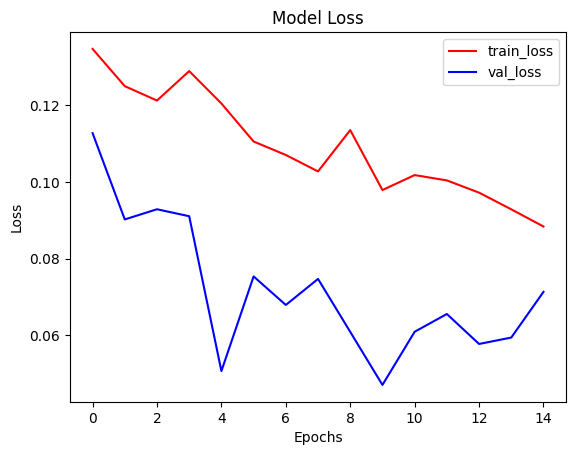

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss,label='train_loss',color='red')
plt.plot(val_loss,label='val_loss',color='blue')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()